In [4]:
import os
os.chdir('../lib')
from SVD import *
import pickle

In [55]:
# set up
als = ALS('../data/ratings.csv', True)
train_data, test_data = als.split(test_size = 0.2)

TypeError: __init__() takes 2 positional arguments but 3 were given

In [56]:
# set up
als = ALS('../data/ratings.csv')
train_data, test_data = als.split(test_size = 0.2)

TypeError: __init__() takes 2 positional arguments but 3 were given

In [32]:
als_best_params = (5, 0.1, 10, 3)
# pickle.dump(als_best_params, open( "../output/als_best_params.p", "wb" ))

In [ ]:
func.err(testdata)

In [31]:
reg_list = [0.1,0.15,0.2,0.25]
rank_list = [5,10,20]
als.gridParams(reg = reg_list, rank = rank_list)
als.params

[(5, 0.1, 10, 3),
 (5, 0.15, 10, 3),
 (5, 0.2, 10, 3),
 (5, 0.25, 10, 3),
 (10, 0.1, 10, 3),
 (10, 0.15, 10, 3),
 (10, 0.2, 10, 3),
 (10, 0.25, 10, 3),
 (20, 0.1, 10, 3),
 (20, 0.15, 10, 3),
 (20, 0.2, 10, 3),
 (20, 0.25, 10, 3)]

In [29]:
als.tuningParams(test_data, measure = 'rmse', verbose = False)

stage (5, 0.1, 10, 3)
Train rmse : 0.15730247986260262   Cross-Validation rmse : 3.13608492415749
Train rmse : 0.15646546385532925   Cross-Validation rmse : 3.510000317863808
Train rmse : 0.16858554188334882   Cross-Validation rmse : 4.23802656147735
Min cv err: 3.13608492415749
stage (10, 0.1, 10, 3)
Train rmse : 0.15873798360837146   Cross-Validation rmse : 3.467502124636618
Train rmse : 0.1574959647994745   Cross-Validation rmse : 3.9975750482533194
Train rmse : 0.16605785883961194   Cross-Validation rmse : 4.582073287307212
Min cv err: 3.467502124636618
stage (20, 0.1, 10, 3)
Train rmse : 0.14981772248940667   Cross-Validation rmse : 3.503392560626259
Train rmse : 0.1463924839963924   Cross-Validation rmse : 3.5078025708554295
Train rmse : 0.15160390189404838   Cross-Validation rmse : 4.622733283608135
Min cv err: 3.503392560626259


In [30]:
als.best_params

(5, 0.1, 10, 3)

In [20]:
als.cv(reg = s[1], rank = s[0], num_epoch = 10, verbose = True)

Train rmse : 0.4639893316929484   Cross-Validation rmse : 2.7441895075188447
Train rmse : 0.4627235342710854   Cross-Validation rmse : 2.719313973879377
Train rmse : 0.4617953103011003   Cross-Validation rmse : 2.7915646847809734


2.719313973879377

rank = 5  : 1.4266937137186813
rank = 10 : 1.908464083374105
rank = 20 :

In [ ]:
func.best_params

### SGD new

In [205]:
import pandas as pd
import numpy as np
import itertools
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import pairwise_distances
import time


class svdData:

    """
    The class for changing data to a format fit ALS algorithm
    """
    def __init__(self, data, R0):

    # Q : the user-item matrix based on given data
    # R : 1 means the data contains user_u to item_i rating, while 0 means doesn't contain
        self.data = data
        self.R0 = R0
        self.ratings = [(uid, iid, float(r)) for (uid, iid, r) in data.itertuples(index=False)]
        self.Q, self.R = self._prepare_QR(self.data)

    # def __init__(self, data):
    #     self.raw = data
    #     self.ratings = [(uid, iid, float(r)) for (uid, iid, r) in data.itertuples(index=False)]
        

    def _prepare_QR(self, data):
        temp = self.R0.copy()
        for u, i, r in self.ratings:
            temp[i][u] = r

        Q = temp.values
        R = (Q > 0) *1
        return Q, R


class SVD:
    """
    The class for performing matrix factorization with Singular Vector Deviation

    Methods for pre-processing:
        1. Stochastic  Gradient Descent
        2. Alternating Least Squares

    Mesures for evaluation:
        1. RMSE: root mean square error
        2. MAE : mean absolute error

    """

    def __init__(self,data_dir, sample = False):
        
        """
        Attributes:
            mean: global mean for rating
            bu  : bias associates with users' rating 
            bi  : bias associates with items' rating
            p   : user-matrix
            q   : item-matrix
        """

        self.df = pd.read_csv(data_dir)
        del self.df['timestamp']
        if sample:
            self.df = self.df[0:1000]
        
        self.mean = np.mean(self.df['rating'])
        self.user_count = len(self.df['userId'].unique())
        self.item_count = len(self.df['movieId'].unique())

        self.data = (self.df.pivot(index='userId', columns='movieId', values='rating')).fillna(0)
        # user-item matrix
        self.Q = self.data.values
        self.R0 = self.data * 0
        self._bu = None
        self._bi = None
        self.p = None
        self.q = None
        self.item_dict = None

        self._K = None
        self.error = None
        self._trainsets = None
        self._testsets = None
        self.params = None
        self.best_params = None



    def split(self,test_size, seed = 0):
        train_data, test_data = train_test_split(self.df, test_size = test_size, random_state = seed)
        train_data = svdData(train_data, self.R0)
        test_data = svdData(test_data, self.R0)
        self._trainsets = [train_data]
        self._testsets = [test_data]
        return train_data , test_data
    
    def sgd(self, data, lr = 0.005,reg = 0.4, rank = 10, num_epoch = 10, seed = 0 , stopping_driv = 0.001, measure = 'rmse', elapse = False):
        """
        A method to perform matrix factorization using Stochastic Gradient Descent

        lr        : learning rate, Defalt: 10
        reg       : regularization parameter: lambda, Defalt: 0.4
        rank      : number of latent variables, Default : 10
        num_epoch : number of iteration of the SGD procedure, Default:10
        seed      : seed of calling random state
        """
        self._algo = 'sgd'
        
        tmp1 = self.df['movieId'].unique()
        self.item_dict = dict(zip(tmp1,[i for i in range(self.item_count)]))
            
        # initialize user matrix and item matrix
        np.random.seed(seed)
        p = np.random.normal(2.5,1, size = (self.user_count, rank))
        q = np.random.normal(2.5,1, size = (self.item_count, rank))

        # initialize bias
        bu = np.zeros(self.user_count)
        bi = np.zeros(self.item_count)

        start_time = time.time()
        for this_epoch in range(num_epoch):
            
            for uid, mid, r in data.ratings:
                u = uid - 1
                i = self.item_dict[mid]

                # prediction
                pred = self.mean + bu[u] + bi[i] + np.dot(p[u,:], q[i,:])          
                err = r - pred
                    
                # update bias
                deriv =(err - reg * bu[u])
                if(np.abs(deriv) > stopping_driv):
                    bu[u] += lr * deriv
                deriv = (err - reg * bi[i])
                if(np.abs(deriv) > stopping_driv):
                    bi[i] += lr * deriv

                for f in range(rank):
                    puf = p[u,f]
                    qif = q[i,f]
                    deriv = (err * qif - reg * puf)
                    if(np.abs(deriv) > stopping_driv):
                        p[u,f]  += lr * deriv
                    deriv = (err * puf - reg * qif)
                    if(np.abs(deriv) > stopping_driv):
                        q[i,f]  += lr * deriv
        end_time = time.time()
        last = round((end_time - start_time), 4)
        if elapse:
            print("Total time: {}s".format(last))
                    
        # update the instance variariables
        self.bu = bu
        self.bi = bi
        self.p = p
        self.q = q
        self.error = self.err(data, measure)
        
        
        
    def als(self, data, rank = 10, reg = 0.1, num_epoch = 10, measure = 'rmse', elapse = False):
        """
        A method to perform matrix factorization using Alternating Least Square

        data      : An svdData format
        reg       : regularization parameter: lambda, Defalt: 0.4
        rank      : number of latent variables, Default : 10
        num_epoch : number of iteration of the SGD procedure, Default:10
        measure   : evaluation method
        elapse    : if true, print the time of fitting 

        """
        self._algo = 'als'
        I = np.eye(rank)
        np.random.seed(0)
        p = np.random.normal(2.5,1, size = (self.Q.shape[0], rank))
        q = np.random.normal(2.5,1, size = (self.Q.shape[1],rank))

        start_time = time.time()
        for this_epoch in range(num_epoch):

            for u, Iu in enumerate(data.R):
                j = np.nonzero(Iu)[0]
                nu = sum(Iu)
                if nu != 0:
                    A = q[j,:].T.dot(q[j,:]) + nu * reg * I
                    r = data.Q[u][data.Q[u]!=0]
                    V = q[j,:].T.dot(r.T)
                    p[u,:] = np.dot(np.linalg.inv(A), V)

            for i, Ii in enumerate(data.R.T):
                j = np.nonzero(Ii)[0]
                ni = sum(Ii)
                if ni != 0:
                    A = p[j,:].T.dot(p[j,:]) + ni * reg * I
                    r = data.Q.T[i][data.Q.T[i]!=0]
                    V = p[j,:].T.dot(r) 
                    q[i,:] = np.dot(np.linalg.inv(A), V)
        end_time = time.time()
        last = round((end_time - start_time), 4)
        if elapse:
             print("Total time: {}s".format(last))
        self.q = q
        self.p = p
        self.error = self.err(data, measure)
        
    def err(self, data, measure = 'rmse'):
        """A method to calculate loss"""
        if self._algo == 'sgd':
            err = 0
            for uid, mid, r in data.ratings:
                u = uid - 1
                i = self.item_dict[mid]

                if measure == 'rmse':
                    # prediction
                    err += (r- self.mean - self.bu[u] - self.bi[i]- np.dot(self.p[u,:], self.q[i,:]))**2
                    return np.sqrt(err/len(data.ratings))
                if measure == 'mae':                
                    return err/len(data.ratings)
        if self._algo == 'als':
            if measure == 'rmse':
                loss = np.sum((data.R * (self.Q - np.dot(self.p, self.q.T))) ** 2)/ np.sum(data.R)
                return np.sqrt(loss)
            if measure == 'mae':
                loss = np.sum(np.abs(data.R * (self.Q - np.dot(self.p, self.q.T))))/ np.sum(data.R) 
                return loss

    def KNN(self, testset, K = 5, measure = 'rmse'):
        self.sim = pairwise_distances(self.p, metric = "cosine")
        err = 0
        for uid, mid, r, in testset.ratings:
            u = uid - 1
            i = self.item_dict[mid]
            neighbors = np.argsort(self.sim[u])[-K-1:-1]
            sum_sim = 0
            sum_rating = 0
            
            
            for k in range(K):
                rate = np.dot(self.p[neighbors[k],:], self.q[i,:])
                if rate > 0:
                    sum_sim += self.sim[u][neighbors[k]]
                    sum_rating += rate * self.sim[u][neighbors[k]]


            est_rating = sum_rating/sum_sim
            if measure == 'rmse':
                err += (r - est_rating) ** 2
                return np.sqrt(err/len(testset.ratings))

    def kfold_split(self, svd_data, K = 3,seed = 0):
        kf = KFold(n_splits= K, random_state = seed, shuffle = True)
        trainsets = []
        testsets = []
        self._K = K
        
        for train_index, test_index in kf.split(svd_data.data):
            trainset = svd_data.data.iloc[train_index,:]
            testset = svd_data.data.iloc[test_index,:]
            
            trainsets.append(svdData(trainset,self.R0))
            testsets.append(svdData(testset,self.R0))
        self._trainsets = trainsets
        self._testsets = testsets
        
    def cv(self, data, measure,lr = 0.005, reg = 0.4, rank = 10, num_epoch = 10, verbose = True, plot = False, seed = 0):
        """A method fo perform cross-validation"""
    
        train_err= [0] * self._K
        test_err = [0] * self._K

        
        for k in range(self._K):
            if self._algo == 'sgd':
                self.sgd(self._trainsets[k], lr = lr,reg = reg,rank = rank,num_epoch = num_epoch)
            if self._algo == 'als':
                self.als(self._trainsets[k], rank = rank, num_epoch = num_epoch, measure = measure)
            train_err[k] = self.error
            test_err[k] = self.err(self._testsets[k], measure)
            if verbose:
                print("Train {} : {}   Cross-Validation {} : {}".format(measure, round(train_err[k],4), measure, round(test_err[k],4)))
            
        if plot:
            x = np.arange(K) + 1
            plt.title("Train error and cross-validation error")
            plt.plot(x,train_err, label = "train error") 
            plt.plot(x,test_err, label = "cv error") 
            plt.xlabel("number of folds")
            plt.ylabel("{}".format(measure))
            plt.legend()
            plt.show()
        
        return np.amin(test_err)
    
    def gridParams(self, algo, lr = [0.005], reg = [0.4] ,rank = [10], num_epoch = [10]):
        params = []
        self._algo = algo
        if self._algo == 'sgd':
            for l, r, rk, np in itertools.product(lr, reg, rank, num_epoch):
                params.append((l, r, rk, np))
        if self._algo == 'als':
            for rk, r, np in itertools.product(rank, reg, num_epoch):
                params.append((rk, r, np))
        self.params = params

    def tuningParams(self,data, K = 3, measure = 'rmse',verbose = False):
        loss = []
        self.kfold_split(data, K= K)
        for comb in self.params: 
            if self._algo == 'sgd':
                err = self.cv(data, measure = measure, lr = comb[0], reg = comb[1], rank = comb[2], num_epoch = comb[3], verbose = verbose)
            if self._algo == 'als':
                err = self.cv(data, measure = measure, reg = comb[1], rank = comb[0], num_epoch = comb[2])
            loss.append(err)
            if verbose:
                print("stage {}".format(comb))
                print("Min cv err: {}".format(err))

        idx = np.argmin(loss)
        self.best_score = loss[idx]
        self.best_params = self.params[idx]
        

## Test

In [206]:
svd = SVD('../data/ratings.csv',True)
trainset, testset = sgd.split(0.2)
svd.kfold_split(trainset)

### SGD

In [207]:
svd.sgd(trainset)

In [208]:
svd.err(testset)

0.17723274833565997

In [209]:
svd.cv(trainset, 'rmse')

Train rmse : 0.0237   Cross-Validation rmse : 0.1238
Train rmse : 0.018   Cross-Validation rmse : 0.0605
Train rmse : 0.0335   Cross-Validation rmse : 0.0042


0.004169835015703391

In [210]:
reg_list = [0.1,0.15]
rank_list = [5,10]
svd.gridParams(algo = 'sgd',reg = reg_list, rank = rank_list)

In [211]:
svd.tuningParams(trainset, verbose = True)

Train rmse : 0.0442   Cross-Validation rmse : 0.1114
Train rmse : 0.0344   Cross-Validation rmse : 0.0832
Train rmse : 0.0424   Cross-Validation rmse : 0.0442
stage (0.005, 0.1, 5, 10)
Min cv err: 0.04422002765081479
Train rmse : 0.0146   Cross-Validation rmse : 0.1307
Train rmse : 0.0117   Cross-Validation rmse : 0.06
Train rmse : 0.0258   Cross-Validation rmse : 0.0214
stage (0.005, 0.1, 10, 10)
Min cv err: 0.021421909866581008
Train rmse : 0.0455   Cross-Validation rmse : 0.1119
Train rmse : 0.0358   Cross-Validation rmse : 0.0827
Train rmse : 0.0436   Cross-Validation rmse : 0.0432
stage (0.005, 0.15, 5, 10)
Min cv err: 0.0431650630538161
Train rmse : 0.0171   Cross-Validation rmse : 0.1292
Train rmse : 0.0136   Cross-Validation rmse : 0.06
Train rmse : 0.0281   Cross-Validation rmse : 0.0156
stage (0.005, 0.15, 10, 10)
Min cv err: 0.015618168619160116


In [212]:
svd.best_params

(0.005, 0.15, 10, 10)

In [140]:
sgd_best_params = pickle.load(open( "../output/sgd_best_params.p", "rb" ))
sgd.sgd(trainset, lr = sgd_best_params[0] ,reg = sgd_best_params[1], rank = sgd_best_params[2],elapse = True)

Total time: 0.7267s


In [213]:
sgd.err(testset)

0.1629564714517793

### ALS

In [214]:
svd.als(trainset)
svd.error

0.20669180324316216

In [215]:
svd.err(testset)

4.522689341988216

In [216]:
reg_list = [0.1,0.15]
rank_list = [5,10]
svd.gridParams(algo = 'als',reg = reg_list, rank = rank_list)

In [217]:
svd.params

[(5, 0.1, 10), (5, 0.15, 10), (10, 0.1, 10), (10, 0.15, 10)]

In [218]:
svd.tuningParams(trainset)

Train rmse : 0.1868   Cross-Validation rmse : 3.3555
Train rmse : 0.1855   Cross-Validation rmse : 3.144
Train rmse : 0.1876   Cross-Validation rmse : 3.3852
Train rmse : 0.1868   Cross-Validation rmse : 3.3555
Train rmse : 0.1855   Cross-Validation rmse : 3.144
Train rmse : 0.1876   Cross-Validation rmse : 3.3852
Train rmse : 0.1979   Cross-Validation rmse : 4.8151
Train rmse : 0.1934   Cross-Validation rmse : 4.7171
Train rmse : 0.1982   Cross-Validation rmse : 5.0645
Train rmse : 0.1979   Cross-Validation rmse : 4.8151
Train rmse : 0.1934   Cross-Validation rmse : 4.7171
Train rmse : 0.1982   Cross-Validation rmse : 5.0645


In [149]:
als_best_params = pickle.load(open( "../output/als_best_params.p", "rb" ))

In [150]:
als_best_params

(5, 0.1, 10, 3)

In [153]:
svd.als(trainset, rank = als_best_params[0], reg = als_best_params[1],elapse = True)

Total time: 0.2512s


In [154]:
svd.err(testset)

3.4686601289217545

### KNN

In [42]:
sgd.KNN(testset)

0.02275047085827895

best K for KNN: 7


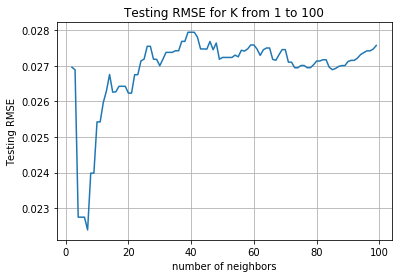

In [43]:
# train K
K_err = []
K_num = [i for i in range(2,100)]
for k in K_num:
    K_err.append(sgd.KNN(testset, K = k))
plt.plot(K_num, K_err)
plt.xlabel("number of neighbors") 
plt.ylabel("Testing RMSE")
plt.title("Testing RMSE for K from 1 to 100")
plt.grid()
best_K = np.argmin(K_err)+2
print("best K for KNN: {}".format(best_K))

In [44]:
temp = [[2,2],[3,4]]

In [11]:
sort = np.argsort(temp)

In [15]:
temp[sort[-3]]

2

In [59]:
class test:
    def __init__(self,data,R0 = None):
        print("yes, 1")
        
    def __init__(self,data, R0):
        print("yes ,2")

In [62]:
test("1",2)

yes ,2
